In [ ]:
# Environment and Core Libraries
import pandas as pd
import numpy as np
import random
import math
import yaml
import os #multithreading

# PennyLane and PyTorch
import pennylane as qml
import torch
from torch.nn import Module, ParameterDict, Parameter
from torch.optim import Adam
from sklearn.model_selection import train_test_split

# Lambeq
from lambeq.backend.quantum import Diagram as LambeqDiagram
from discopy.quantum import gates
import spacy
import discopy
from lambeq import BobcatParser, Rewriter, IQPAnsatz, SpacyTokeniser, AtomicType
from discopy.rigid import Ty

#data handling and plotting
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Patch for discopy
monoidal_module = getattr(discopy, "monoidal", None)
if monoidal_module:
    diagram_class = getattr(monoidal_module, "Diagram", None)
    if diagram_class and not hasattr(diagram_class, "is_mixed"):
        diagram_class.is_mixed = property(lambda self: False)

# Load spacy model
spacy.load('en_core_web_sm')


In [9]:
#Data Loading Function
def load_data(csv_file, sample_fraction=1.0):
    sentences1, sentences2, is_duplicate = [], [], []
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')
        if sample_fraction < 1.0:
            df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
        
        sentences1 = df['question1'].astype(str).tolist()
        sentences2 = df['question2'].astype(str).tolist()
        is_duplicate = df['is_duplicate'].tolist()
        
        print(f"Loaded {len(sentences1)} sentence pairs.")
        return sentences1, sentences2, is_duplicate
    except Exception as e:
        print(f"An error occurred: {e}")
        return [], [], []

def create_balanced_training_set(training_data: list) -> list:
    """Creates a balanced training set by undersampling the majority class."""
    positives = [pair for pair in training_data if pair['label'] == 1]
    negatives = [pair for pair in training_data if pair['label'] == 0]
    
    # Undersample the larger class to match the size of the smaller class
    if len(positives) > len(negatives):
        positives = random.sample(positives, len(negatives))
    else:
        negatives = random.sample(negatives, len(positives))
    
    balanced_train_set = positives + negatives
    random.shuffle(balanced_train_set)
    
    print(f"Created a balanced training set with {len(positives)} positive and {len(negatives)} negative pairs.")
    return balanced_train_set

In [3]:
#Plotting functions
def plot_training_history(history):
    if not history:
        print("History is empty. Cannot plot.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(history, label='Average Loss per Epoch')
    plt.title('Training Loss Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('Average Penalized Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_parameter_history(param_history):
    if not param_history:
        print("Parameter history is empty. Cannot plot.")
        return

    epochs = range(len(param_history))
    means = [d['mean'] for d in param_history]
    stds = [d['std'] for d in param_history]
    mins = [d['min'] for d in param_history]
    maxs = [d['max'] for d in param_history]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, means, label='Mean Parameter Value')
    plt.fill_between(epochs, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2, label='1 Std. Deviation')
    plt.plot(epochs, mins, linestyle='--', color='gray', label='Min/Max Range')
    plt.plot(epochs, maxs, linestyle='--', color='gray')
    
    plt.title('Evolution of Model Parameters During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Parameter Value')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_parameter_evolution_polar(param_history):
    if not param_history:
        print("Parameter history is empty. Cannot plot.")
        return
    # Use a slightly larger figure for polar plots
    plt.figure(figsize=(8, 8))
    
    # Create a polar subplot
    ax = plt.subplot(111, projection='polar')

    epochs = np.array(range(len(param_history)))
    # We use modulo 2*pi to keep the angles in one circle
    mean_angles = np.array([d['mean'] for d in param_history]) % (2 * np.pi)

    # The radius will be the epoch number, so the path spirals outwards over time
    # The angle will be the mean parameter value
    ax.plot(mean_angles, epochs, 'o-', label='Mean Parameter Path')

    # Add markers for the start and end points for clarity
    if len(epochs) > 0:
        ax.plot(mean_angles[0], epochs[0], 'gX', markersize=12, label='Start')
        ax.plot(mean_angles[-1], epochs[-1], 'rX', markersize=12, label='End')

    # Formatting the plot
    ax.set_theta_zero_location('N') # pyright: ignore[reportAttributeAccessIssue] # Set 0 degrees to the top
    ax.set_theta_direction(-1) # pyright: ignore[reportAttributeAccessIssue] # Make it clockwise
    ax.set_rlabel_position(0) # pyright: ignore[reportAttributeAccessIssue]
    ax.set_rlim(0, len(epochs) * 1.05) # pyright: ignore[reportAttributeAccessIssue] # Set radius limit
    ax.set_xlabel("Epoch") # The radius represents the epoch
    ax.set_title('Cyclical Evolution of Mean Parameter', pad=20)
    ax.legend()
    plt.show()
def plot_parameter_deltas(param_history):
    if len(param_history) < 2:
        print("Need at least 2 epochs to plot parameter deltas.")
        return

    mean_angles = np.array([d['mean'] for d in param_history])
    
    # Calculate the shortest angle difference between each epoch
    deltas = []
    for i in range(1, len(mean_angles)):
        prev_angle = mean_angles[i-1]
        curr_angle = mean_angles[i]
        delta = np.arctan2(np.sin(curr_angle - prev_angle), np.cos(curr_angle - prev_angle))
        deltas.append(delta)

    plt.figure(figsize=(10, 6))
    # We plot against epochs 1 to N, since the first delta occurs at epoch 1
    plt.plot(range(1, len(mean_angles)), deltas, 'o-', label='Change in Mean Parameter (Delta)')
    
    plt.axhline(0, color='red', linestyle='--', label='No Change')
    plt.title('Epoch-to-Epoch Change in Mean Parameter Value')
    plt.xlabel('Epoch')
    plt.ylabel('Shortest Angle Difference (Radians)')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, len(mean_angles)))
    plt.show()


def plot_confusion_matrix(y_true, y_pred, threshold=0.5):
    """
    Computes and plots a confusion matrix.
    
    Args:
        y_true (np.array): The ground-truth labels (0s and 1s).
        y_pred (np.array): The model's raw probability predictions (overlaps from 0 to 1).
        threshold (float): The cutoff for classifying a prediction as 1.
    """
    # Convert probability predictions to binary 0/1 predictions
    binary_preds = (y_pred >= threshold).astype(int)
    
    cm = confusion_matrix(y_true, binary_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Non-Duplicate', 'Predicted Duplicate'],
                yticklabels=['Actual Non-Duplicate', 'Actual Duplicate'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
def plot_roc_curve(y_true, y_pred):
    """
    Computes and plots the ROC curve and AUC score.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [ ]:
# QNLP MODEL AND TRAINING PIPELINE
# 1. THE QNLP MODEL CLASS
# ===============================================================
class QNLPModel(Module):
    def __init__(self, symbols):
        super().__init__()
        # Initialize parameters from a normal distribution with a small standard deviation
        self.params = ParameterDict()
        for s in symbols:
            self.params[s.name.replace('.', '_')] = Parameter(torch.randn(1) * 0.1)

    def initialise_weights(self):
        """Re-initialises the weights of the model."""
        for param in self.params.values():
            param.data.normal_(0, 0.1) # Modify tensor in-place

    def forward(self, diagram):
        param_values = [self.params[s.name.replace('.', '_')] for s in diagram.free_symbols]
        if not param_values:
            return torch.tensor([])
        return torch.cat(param_values)

# ===============================================================
# 2. HELPER FUNCTIONS
# ===============================================================
def FischerInformation(Fidelity):
    """Calculates the Fubini-Study distance from the fidelity."""
    rootFidelity = math.sqrt(abs(Fidelity))
    clamped_val = max(-1.0, min(1.0, rootFidelity))
    return math.acos(clamped_val)

def get_diagram_width(diagram):
    """Calculates the true maximum width of a diagram at any point."""
    if not diagram.boxes:
        return len(diagram.cod)
    # The width is the maximum wire index a box acts on.
    return max(
        [offset + len(box.dom) for box, offset in zip(diagram.boxes, diagram.offsets)]
        + [len(diagram.cod)]
    )
    
def execute_discopy_diagram(diagram, params, wires, embedding_method='simple_pad'):
    """
    Executes a DisCoPy/lambeq diagram's instructions on a specific set of wires,
    and optionally applies an entangling layer afterwards.
    """
    # Step 1: Execute the original sentence diagram as before
    wire_map = {i: w for i, w in enumerate(wires)}
    param_idx = 0
    for gate, offset in zip(diagram.boxes, diagram.offsets):
        if hasattr(qml, gate.name):
            op = getattr(qml, gate.name)
            gate_params = []
            num_params = len(gate.free_symbols)
            if num_params > 0:
                gate_params = params[param_idx : param_idx + num_params]
                param_idx += num_params
            target_wires = [wire_map[i + offset] for i in range(len(gate.dom))]
            op(*gate_params, wires=target_wires)

    # Step 2: If the method is 'entangle', apply an entangling layer
    if embedding_method == 'entangle':
        # Entangle every wire with its neighbor in a circular pattern
        for i in range(len(wires)):
            qml.CNOT(wires=[wires[i], wires[(i + 1) % len(wires)]])
# ===============================================================
# 3. PREPROCESSING FUNCTION
# ===============================================================
def preprocess_data_for_model(data_pairs, Tokeniser, ansatz, parser, rewriter, qubit_limit=20):
    print(f"Starting preprocessing with a qubit limit of {qubit_limit}...")
    filtered_pairs, all_symbols, n_max = [], set(), 0
    for s1, s2, is_duplicate in data_pairs:
        try:
            d1 = ansatz(rewriter(parser.sentence2diagram(Tokeniser.tokenise_sentence(s1), tokenised=True)))
            d2 = ansatz(rewriter(parser.sentence2diagram(Tokeniser.tokenise_sentence(s2), tokenised=True)))
            width1 = get_diagram_width(d1)
            width2 = get_diagram_width(d2)
            if width1 <= qubit_limit and width2 <= qubit_limit:
                pair_data = {
                    's1': s1, 's2': s2, 'label': is_duplicate, 'd1': d1, 'd2': d2,
                    'structural_disparity': abs(len(d1.cod) - len(d2.cod)),
                    'width1': width1,
                    'width2': width2
                }
                filtered_pairs.append(pair_data)
                all_symbols.update(d1.free_symbols)
                all_symbols.update(d2.free_symbols)
                n_max = max(n_max, width1, width2)
        except Exception:
            continue
    print(f"Preprocessing complete. Found {len(filtered_pairs)} valid pairs.")
    print(f"Total unique parameters (symbols) found: {len(all_symbols)}")
    print(f"N_Max for the filtered dataset is: {n_max}")
    return filtered_pairs, sorted(list(all_symbols), key=lambda s: s.name), n_max

# ===============================================================
# 4. THE TRAINING FUNCTION (with Adam & Param Tracking)
# ===============================================================
def train_model_state_vector(data, symbols, n_max, base_learning_rate, lambda_penalty, epochs, embedding_method='entangle'):
    model = QNLPModel(symbols)
    optimizer = Adam(model.parameters(), lr=base_learning_rate) 
    swap_dev = qml.device("lightning.qubit", wires=1 + 2 * n_max)

    loss_history = []
    param_history = []
    print("--- Starting training with EXPLICIT gradient calculation ---")

    for epoch in range(epochs):
        total_loss_epoch, num_trained_pairs = 0, 0
        for i, pair in enumerate(data):
            
            params1_torch, params2_torch = model(pair['d1']), model(pair['d2'])
            if params1_torch.nelement() == 0 or params2_torch.nelement() == 0:
                continue

            num_trained_pairs += 1

            def cost_fn(p1_np, p2_np):
                @qml.qnode(swap_dev)
                def swap_test_qnode(p1, p2):
                    qml.Hadamard(wires=0)
                    
                    # Execute the diagrams with the chosen embedding method
                    execute_discopy_diagram(
                        pair['d1'], p1, wires=range(1, 1 + n_max), 
                        embedding_method=embedding_method)
                    execute_discopy_diagram(
                        pair['d2'], p2, wires=range(1 + n_max, 1 + 2 * n_max), 
                        embedding_method=embedding_method)

                    for j in range(n_max):
                        qml.CSWAP(wires=[0, 1 + j, 1 + n_max + j])
                    qml.Hadamard(wires=0)
                    return qml.expval(qml.PauliZ(0))
                
                measured_overlap = swap_test_qnode(p1_np, p2_np)
                fidelity_loss = (measured_overlap - pair['label'])**2
                structural_penalty = lambda_penalty * pair['structural_disparity']
                return fidelity_loss + structural_penalty

            params1_np = params1_torch.detach().numpy()
            params2_np = params2_torch.detach().numpy()

            grad_fn = qml.grad(cost_fn, argnum=[0, 1])
            grads_np_tuple = grad_fn(params1_np, params2_np)
            
            optimizer.zero_grad()
            
            grad_dict = {}
            param_idx = 0
            for sym in pair['d1'].free_symbols:
                sanitized_name = sym.name.replace('.', '_')
                grad_dict[sanitized_name] = grads_np_tuple[0][param_idx]# pyright: ignore
                param_idx += 1
            
            param_idx = 0
            for sym in pair['d2'].free_symbols:
                sanitized_name = sym.name.replace('.', '_')
                if sanitized_name in grad_dict:
                    grad_dict[sanitized_name] += grads_np_tuple[1][param_idx]# pyright: ignore
                else:
                    grad_dict[sanitized_name] = grads_np_tuple[1][param_idx]# pyright: ignore
                param_idx += 1

            for name, param in model.named_parameters():
                if name in grad_dict:
                    param.grad = torch.tensor(grad_dict[name])
            
            optimizer.step()
            
            loss_val = cost_fn(params1_np, params2_np)
            total_loss_epoch += loss_val
        
        avg_loss = total_loss_epoch / num_trained_pairs if num_trained_pairs > 0 else 0
        loss_history.append(avg_loss)

        all_params = torch.cat([p.data.flatten() for p in model.parameters()]).detach().numpy()
        if all_params.size > 0:
            param_history.append({'mean': np.mean(all_params), 'std': np.std(all_params),
                                  'min': np.min(all_params), 'max': np.max(all_params)})
        
        print(f"Epoch {epoch+1}/{epochs}, Average Penalized Loss: {avg_loss:.4f}")
        
    return model, loss_history, param_history
# Add BASIS_STATES as an argument to the function definition
def train_model_process_tomography(data, symbols, n_max, base_learning_rate, lambda_penalty, epochs, embedding_method, BASIS_STATES):
    model = QNLPModel(symbols)
    optimizer = Adam(model.parameters(), lr=base_learning_rate) 
    swap_dev = qml.device("lightning.qubit", wires=1 + 2 * n_max)

    loss_history = []
    param_history = []
    print("--- Starting training with ALGORITHM 2: Variational Quantum Process Learning ---")

    for epoch in range(epochs):
        total_loss_epoch, num_trained_pairs = 0, 0
        for i, pair in enumerate(data):
            
            params1_torch, params2_torch = model(pair['d1']), model(pair['d2'])
            if params1_torch.nelement() == 0 or params2_torch.nelement() == 0:
                continue

            num_trained_pairs += 1

            def cost_fn(p1_np, p2_np, basis_state_str):
                @qml.qnode(swap_dev)
                def swap_test_qnode(p1, p2):
                    basis_state_array = [int(bit) for bit in basis_state_str]
                    qml.BasisState(basis_state_array, wires=range(1, 1 + n_max))
                    qml.BasisState(basis_state_array, wires=range(1 + n_max, 1 + 2 * n_max))
                    
                    qml.Hadamard(wires=0)
                    
                    execute_discopy_diagram(
                        pair['d1'], p1, wires=range(1, 1 + n_max), 
                        embedding_method=embedding_method)
                    execute_discopy_diagram(
                        pair['d2'], p2, wires=range(1 + n_max, 1 + 2 * n_max), 
                        embedding_method=embedding_method)

                    for j in range(n_max):
                        qml.CSWAP(wires=[0, 1 + j, 1 + n_max + j])
                    qml.Hadamard(wires=0)
                    return qml.expval(qml.PauliZ(0))
                
                measured_overlap = swap_test_qnode(p1_np, p2_np)
                fidelity_loss = (measured_overlap - pair['label'])**2
                structural_penalty = lambda_penalty * pair['structural_disparity']
                return fidelity_loss + structural_penalty

            params1_np = params1_torch.detach().numpy()
            params2_np = params2_torch.detach().numpy()

            accumulated_grads_p1 = np.zeros_like(params1_np)
            accumulated_grads_p2 = np.zeros_like(params2_np)
            total_loss_for_pair = 0

            for basis_state in BASIS_STATES:
                cost_for_grad = lambda p1, p2: cost_fn(p1, p2, basis_state_str=basis_state)
                
                grad_fn = qml.grad(cost_for_grad, argnum=[0, 1])
                grads_np_tuple = grad_fn(params1_np, params2_np)
                
                accumulated_grads_p1 += grads_np_tuple[0]# pyright: ignore
                accumulated_grads_p2 += grads_np_tuple[1]# pyright: ignore
                total_loss_for_pair += cost_for_grad(params1_np, params2_np)
            
            avg_grads_p1 = accumulated_grads_p1 / len(BASIS_STATES)
            avg_grads_p2 = accumulated_grads_p2 / len(BASIS_STATES)
            
            optimizer.zero_grad()
            
            grad_dict = {}
            for i, sym in enumerate(pair['d1'].free_symbols):
                grad_dict[sym.name.replace('.', '_')] = avg_grads_p1[i]
            
            for i, sym in enumerate(pair['d2'].free_symbols):
                sanitized_name = sym.name.replace('.', '_')
                if sanitized_name in grad_dict:
                    grad_dict[sanitized_name] += avg_grads_p2[i]
                else:
                    grad_dict[sanitized_name] = avg_grads_p2[i]

            for name, param in model.named_parameters():
                if name in grad_dict:
                    param.grad = torch.tensor(grad_dict[name])
            
            optimizer.step()
            
            avg_loss_for_pair = total_loss_for_pair / len(BASIS_STATES)
            total_loss_epoch += avg_loss_for_pair
        
        avg_loss = total_loss_epoch / num_trained_pairs if num_trained_pairs > 0 else 0
        loss_history.append(avg_loss)

        all_params = torch.cat([p.data.flatten() for p in model.parameters()]).detach().numpy()
        if all_params.size > 0:
            param_history.append({'mean': np.mean(all_params), 'std': np.std(all_params),
                                  'min': np.min(all_params), 'max': np.max(all_params)})
        
        print(f"Epoch {epoch+1}/{epochs}, Average Penalized Loss: {avg_loss:.4f}")
        
    return model, loss_history, param_history
# ===============================================================
# 5. Inference Function
# ===============================================================
def evaluate_model(model, test_data, n_max, embedding_method='entangle'):
    """
    Evaluates a trained model on a test dataset without updating weights.
    """
    print("\n--- Starting Evaluation on Test Set ---")
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    swap_dev = qml.device("lightning.qubit", wires=1 + 2 * n_max)
    
    predictions = []
    true_labels = []
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for i, pair in enumerate(test_data):
            params1, params2 = model(pair['d1']), model(pair['d2'])
            
            # Skip pairs with no parameters, as they can't be processed
            if params1.nelement() == 0 or params2.nelement() == 0:
                continue

            @qml.qnode(swap_dev, interface="torch")
            def swap_test_qnode(p1, p2):
                qml.Hadamard(wires=0)
                execute_discopy_diagram(pair['d1'], p1, wires=range(1, 1 + n_max))
                execute_discopy_diagram(pair['d2'], p2, wires=range(1 + n_max, 1 + 2 * n_max))
                for j in range(n_max):
                    qml.CSWAP(wires=[0, 1 + j, 1 + n_max + j])
                qml.Hadamard(wires=0)
                return qml.expval(qml.PauliZ(0))
            
            # Get the model's prediction (the overlap)
            measured_overlap = swap_test_qnode(params1, params2)
            
            predictions.append(measured_overlap.item())
            true_labels.append(pair['label'])

    # --- Calculate and Report Metrics ---
    if not predictions:
        print("No valid pairs in the test set to evaluate.")
        return

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    # Calculate Mean Squared Error
    mse = np.mean((predictions - true_labels)**2)
    print(f"Test Set Mean Squared Error (MSE): {mse:.4f}")

    # Calculate simple accuracy (is overlap > 0.5 a correct prediction?)
    binary_preds = (predictions > 0.5).astype(int)
    accuracy = np.mean(binary_preds == true_labels) * 100
    print(f"Test Set Accuracy: {accuracy:.2f}%")
    print("\n--- Evaluation Plots ---")
    plot_confusion_matrix(true_labels, predictions)
    plot_roc_curve(true_labels, predictions)


Configuration loaded:
data:
  path: <ABSOLUTE_PATH_TO_YOUR_QUESTIONS.CSV>
  qubit_limit: 12
  sample_fraction: 0.1
  test_size: 0.2
qnlp:
  embedding_method: entangle
  n_layers: 1
  rewrite_rules:
  - curry
  - prepositional_phrase
  - determiner
training:
  algorithm: state_vector
  base_learning_rate: 0.01
  epochs: 15
  lambda_penalty: 0.1

Loaded 40435 sentence pairs.
Starting preprocessing with a qubit limit of 12...
Preprocessing complete. Found 1012 valid pairs.
Total unique parameters (symbols) found: 7081
N_Max for the filtered dataset is: 12
Created a balanced training set with 301 positive and 301 negative pairs.

Original data split into 602 pairs for training and 203 pairs for testing.
--- Starting training with EXPLICIT gradient calculation ---


c:\Users\Jash\Documents\Research\Semantic Equivilance\.venv\Lib\site-packages\autograd\tracer.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch 1/15, Average Penalized Loss: 0.3668
Epoch 2/15, Average Penalized Loss: 0.3668
Epoch 3/15, Average Penalized Loss: 0.3668
Epoch 4/15, Average Penalized Loss: 0.3668
Epoch 5/15, Average Penalized Loss: 0.3668
Epoch 6/15, Average Penalized Loss: 0.3668
Epoch 7/15, Average Penalized Loss: 0.3668
Epoch 8/15, Average Penalized Loss: 0.3668
Epoch 9/15, Average Penalized Loss: 0.3668
Epoch 10/15, Average Penalized Loss: 0.3668
Epoch 11/15, Average Penalized Loss: 0.3668
Epoch 12/15, Average Penalized Loss: 0.3668
Epoch 13/15, Average Penalized Loss: 0.3668
Epoch 14/15, Average Penalized Loss: 0.3668
Epoch 15/15, Average Penalized Loss: 0.3668

--- Starting Evaluation on Test Set ---
Test Set Mean Squared Error (MSE): 0.3861
Test Set Accuracy: 58.13%

--- Evaluation Plots ---


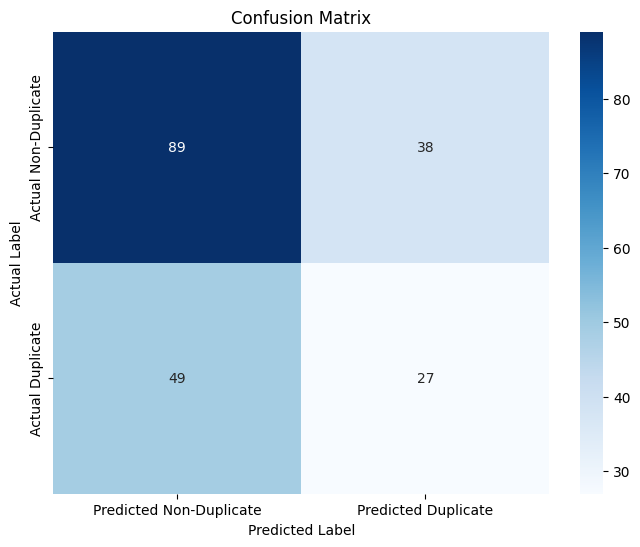

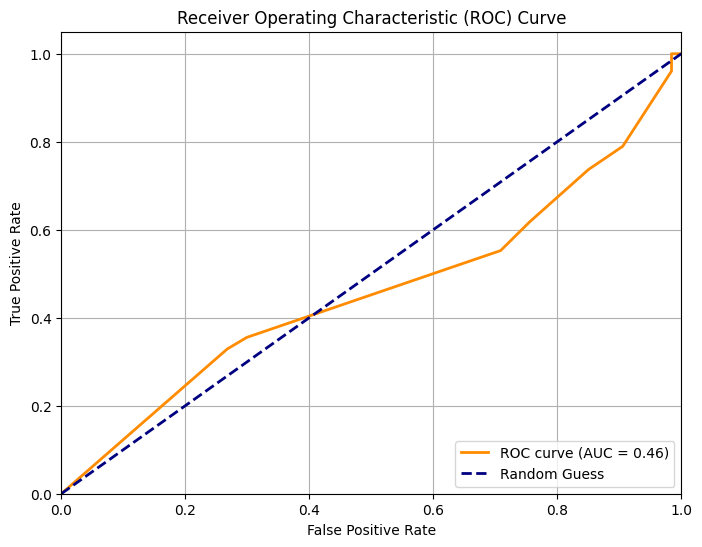


--- Training Analysis ---


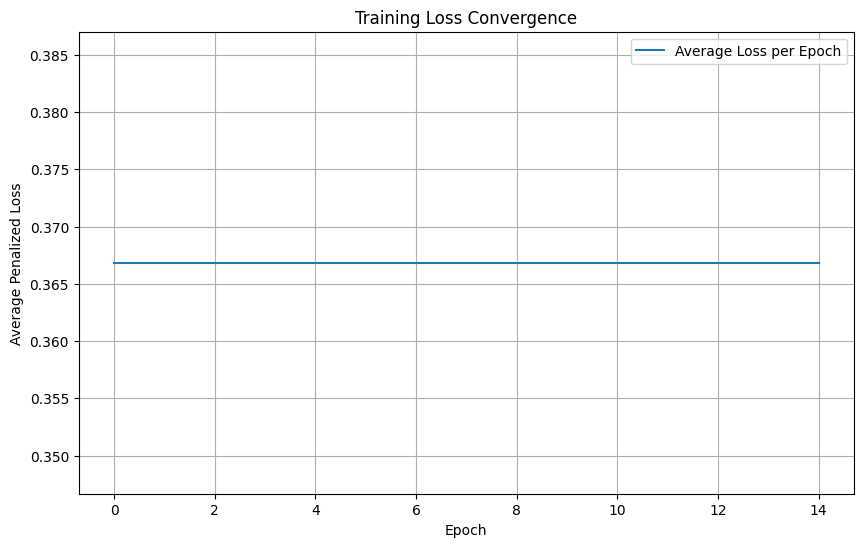

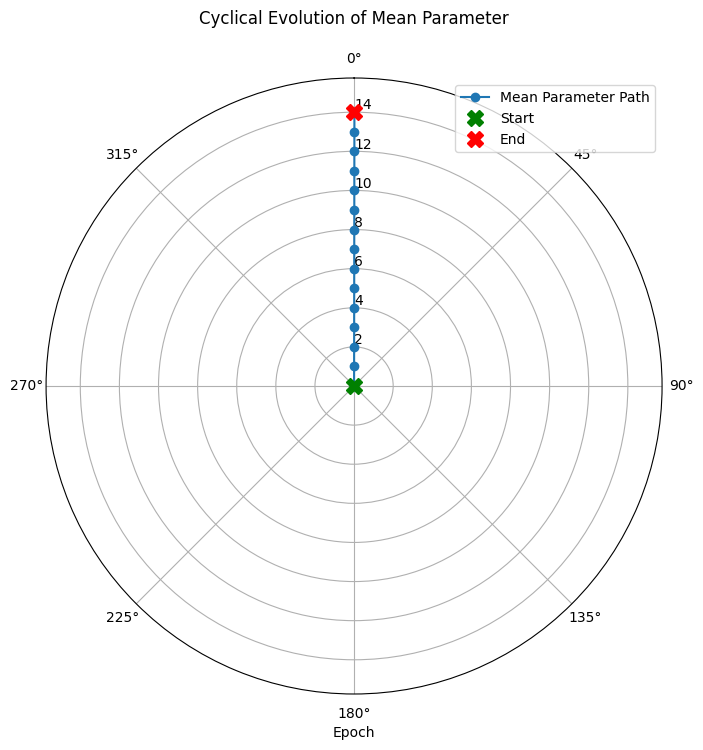

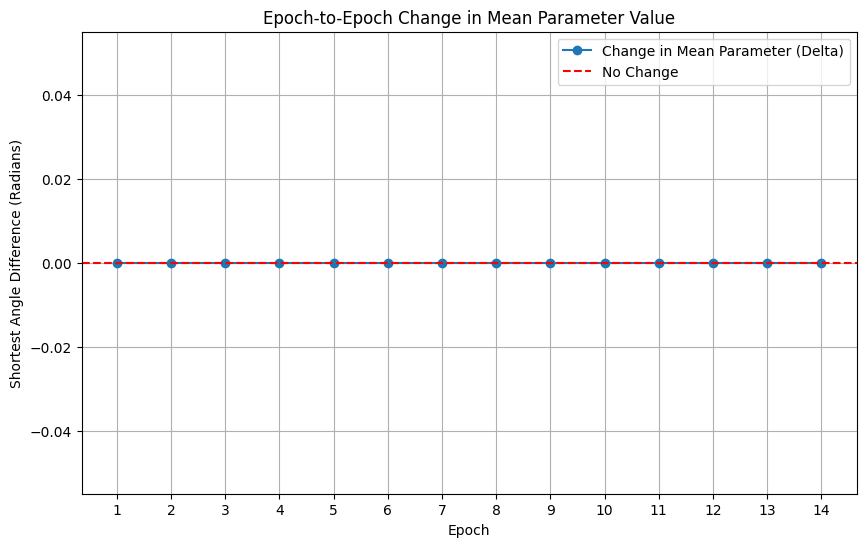


--- Interactive Sentence Comparison ---
Enter two sentences to compare their semantic similarity.
Type 'quit' or 'exit' to stop.


In [ ]:
#Click this to run model
# ===============================================================
# MAIN EXECUTION BLOCK (with Configuration File)
# ===============================================================
def main(config_path: str):
    """Main function to run the entire workflow from a config file."""
    
    # --- 1. Load Configuration ---
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    print("Configuration loaded:")
    print(yaml.dump(config, indent=2))
    
    #Set CPU cores for Simulator
    if 'simulation' in config and 'cpu_cores' in config['simulation']:
        num_cores = config['simulation']['cpu_cores']
        if num_cores and num_cores > 0:
            os.environ["OMP_NUM_THREADS"] = str(num_cores)
            print(f"Set CPU cores for simulation to: {num_cores}\n")
            
    # --- 2. Initialize Objects from Config ---
    tokeniser = SpacyTokeniser()
    parser = BobcatParser()
    rewriter = Rewriter(config['qnlp']['rewrite_rules'])
    
    N = AtomicType.NOUN
    S = AtomicType.SENTENCE
    OB_MAP: dict[Ty, int] = { N: 1, S: 1 }# pyright: ignore

    ansatz = IQPAnsatz(OB_MAP, n_layers=config['qnlp']['n_layers'])# pyright: ignore

    # --- 3. Load and Preprocess Data ---
    sentences1, sentences2, value = load_data(
        config['data']['path'], 
        sample_fraction=config['data']['sample_fraction']
    )
    data_pairs = list(zip(sentences1, sentences2, value))
    
    filtered_data, symbols, n_max = preprocess_data_for_model(
        data_pairs, tokeniser, ansatz, parser, rewriter, 
        qubit_limit=config['data']['qubit_limit']
    )
    
    if filtered_data and n_max > 0:
        # --- 4. Create Datasets ---
        labels = [pair['label'] for pair in filtered_data]
        train_data_raw, test_data = train_test_split(
            filtered_data, test_size=config['data']['test_size'], 
            random_state=42, stratify=labels
        )
        training_data = create_balanced_training_set(train_data_raw)
        print(f"\nOriginal data split into {len(training_data)} pairs for training and {len(test_data)} pairs for testing.")
        
        # --- 5. CHOOSE AND RUN THE CORRECT TRAINING ALGORITHM ---
        training_algorithm = config['training']['algorithm']
        
        if training_algorithm == 'state_vector':
            # Call the fast, default training function
            trained_model, loss_history, param_history = train_model_state_vector(
                training_data, symbols, n_max,
                base_learning_rate=config['training']['base_learning_rate'],
                lambda_penalty=config['training']['lambda_penalty'],
                epochs=config['training']['epochs'],
                embedding_method=config['qnlp']['embedding_method']
            )
        elif training_algorithm == 'process_tomography':
            if n_max > 5:
                print(f"\nWarning: n_max is {n_max}. Training will be extremely slow.")
    
            # Generate basis states locally
            BASIS_STATES = [format(i, f'0{n_max}b') for i in range(2**n_max)]
            print(f"Generated {len(BASIS_STATES)} basis states for n_max={n_max}.")
    
    # Call the advanced, slow training function and PASS BASIS_STATES
            trained_model, loss_history, param_history = train_model_process_tomography(
            training_data, symbols, n_max,
            base_learning_rate=config['training']['base_learning_rate'],
            lambda_penalty=config['training']['lambda_penalty'],
            epochs=config['training']['epochs'],
            embedding_method=config['qnlp']['embedding_method'],
            BASIS_STATES=BASIS_STATES  
    )
        else:
            raise ValueError(f"Unknown training algorithm in config: '{training_algorithm}'")

        # --- 6. Evaluate and Plot ---
        # Note: You may want to create a separate evaluate function for algorithm 2 later
        evaluate_model(trained_model, test_data, n_max)
        print("\n--- Training Analysis ---")
        plot_training_history(loss_history)
        plot_parameter_evolution_polar(param_history)
        plot_parameter_deltas(param_history)
    else:
        print("\nNo data to train on. Please check your config file.")
if __name__ == '__main__':
    config_file_path = 'config.yaml'
    main(config_file_path)